# Feature Map 시각화란?
**Feature Map(특징 맵)**은 각 레이어의 필터(filter)가 입력 이미지의 특정 패턴에 반응한 결과입니다. 
CNN의 각 필터는 입력 이미지에서 특정 패턴(예: 엣지, 텍스처, 모양 등)을 감지하고, 이러한 필터가 활성화된 정도를 시각화한 것이 바로 이 특징 맵입니다.


## 첫 번째 레이어:

감지하는 것: 기본적인 특징, 예를 들면 엣지(edge), 경계선, 모서리, 그리고 단순한 색상이나 질감 패턴 등을 감지합니다. 
이 레이어에서는 입력 이미지와 어느 정도 유사성을 유지하는 특징 맵(feature map)을 보게 될 것입니다. 이는 저수준(low-level) 패턴을 감지하기 때문입니다.
시각적 모양: 첫 번째 레이어에서는 입력 이미지(강아지 같은 이미지)의 윤곽선이나 엣지 감지 패턴을 시각적으로 확인할 수 있습니다.


## 중간 레이어:

감지하는 것: 이 레이어들은 저수준 특징들을 결합하여 더 복잡한 패턴을 감지합니다. 
예를 들어, 특정 모양이나 물체의 일부분 등을 학습합니다.
시각적 모양: 이 시점에서는 특징 맵이 점점 더 추상적이고 복잡한 모양으로 변해갑니다. 
원본 이미지와의 직접적인 유사성은 줄어들고, 대신 다양한 패턴이 나타나기 시작합니다. 다소 노이즈가 섞인 것처럼 보일 수 있습니다.


## 깊은 레이어:

감지하는 것: 이 레이어들은 고수준의 추상적인 특징을 감지합니다. 
학습 과정에서 모델이 분류하는데 중요한 물체의 세부 정보에 집중하게 됩니다. 
이 레이어들은 클래스에 특화된 정보를 학습하며, 더 이상 원본 이미지와의 직접적인 연관성을 가질 필요는 없습니다.
시각적 모양: 특징 맵은 매우 추상적이고 특정 클래스에 관련된 부분만 강조될 수 있습니다. 
따라서, 이 레이어에서는 매우 간결하고 추상적인 모양이 나타나는 것이 일반적입니다.


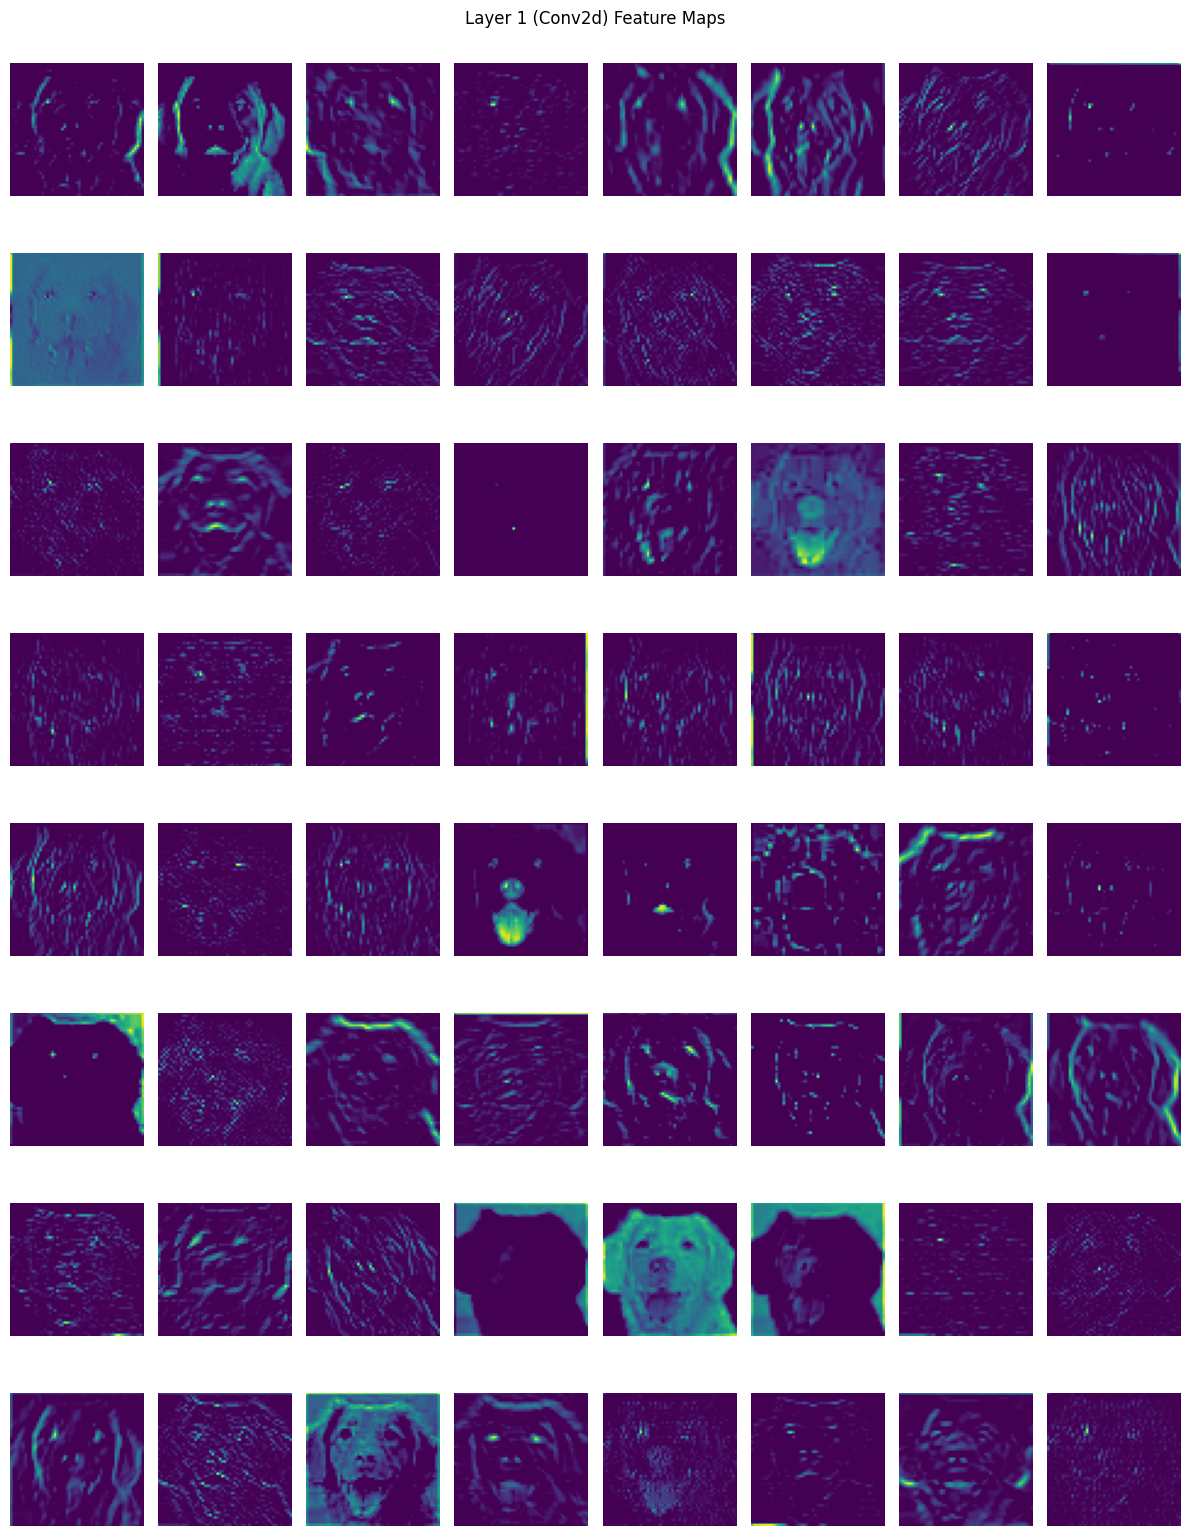

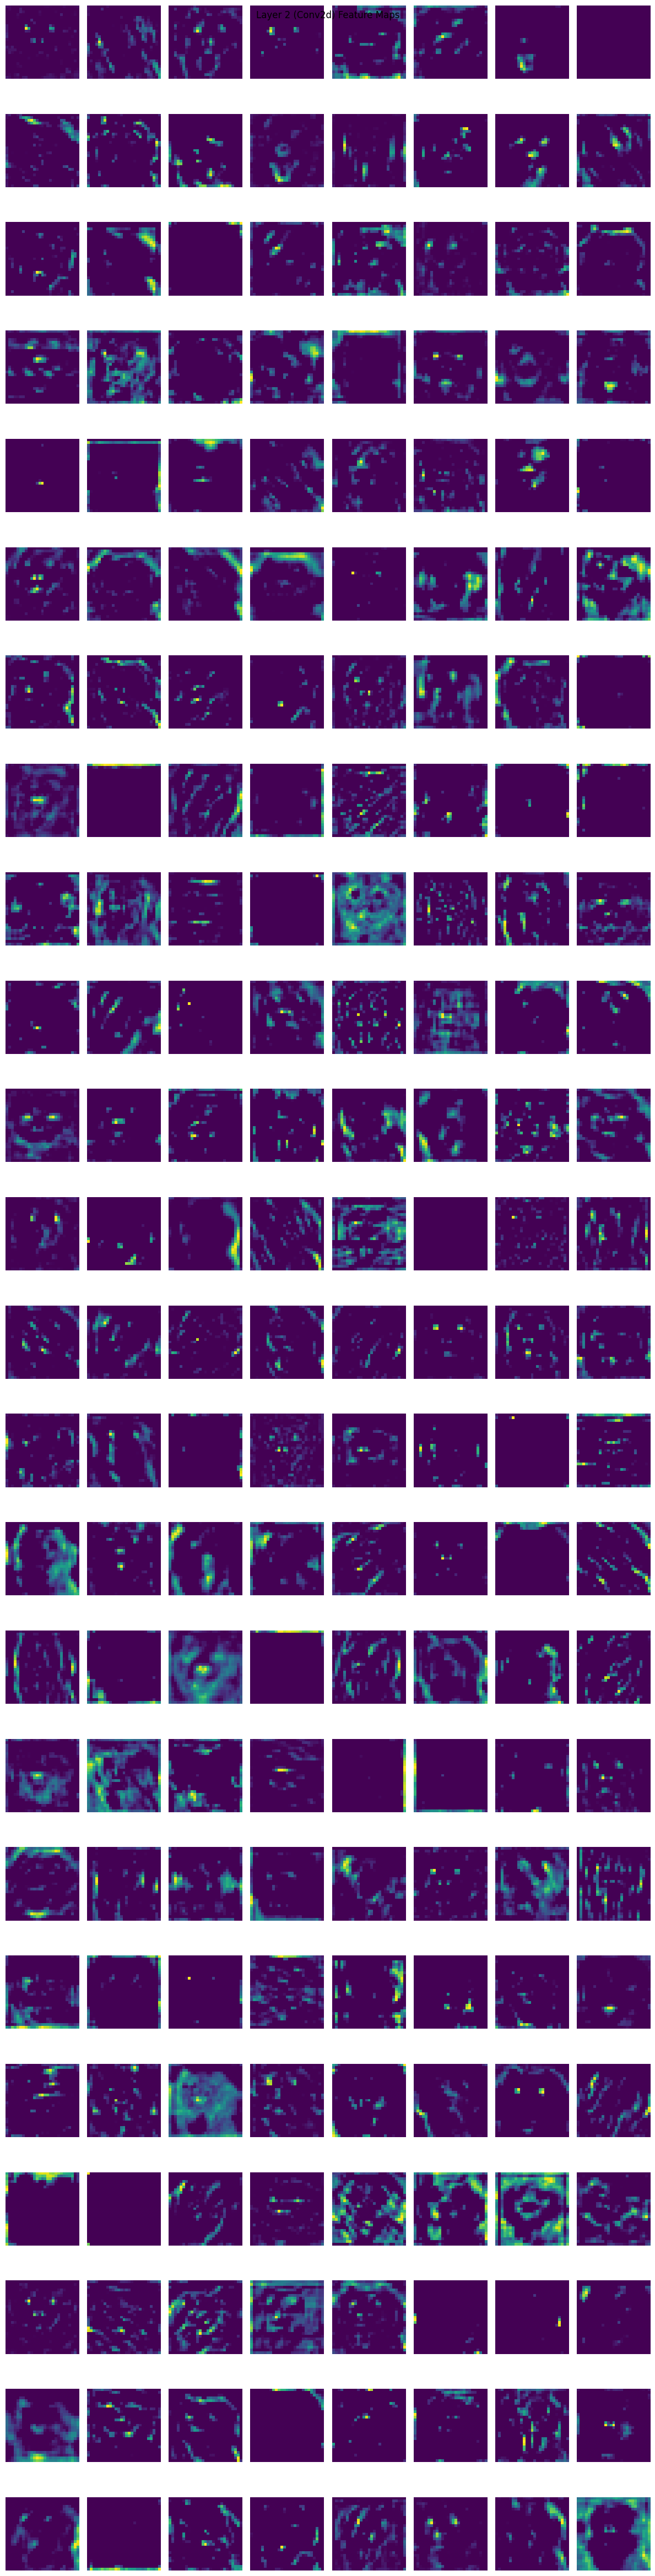

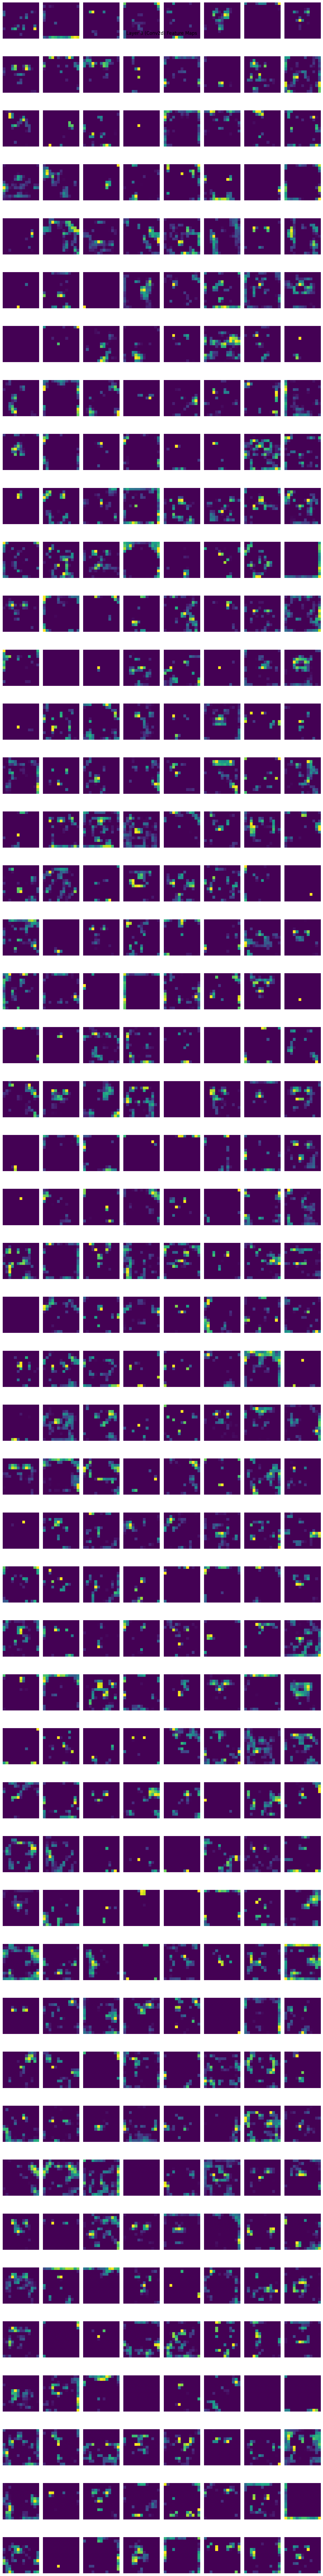

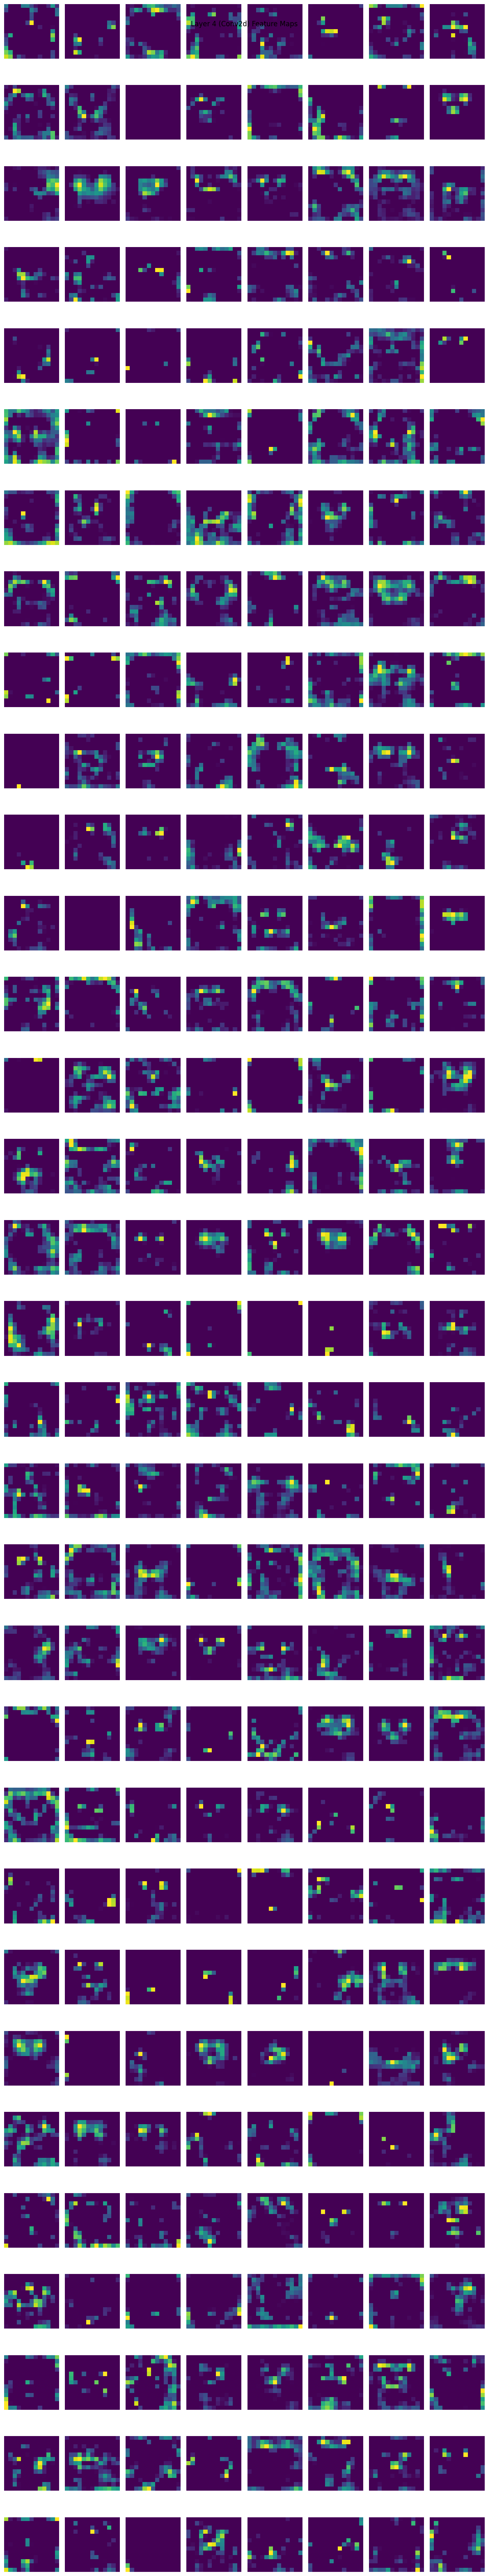

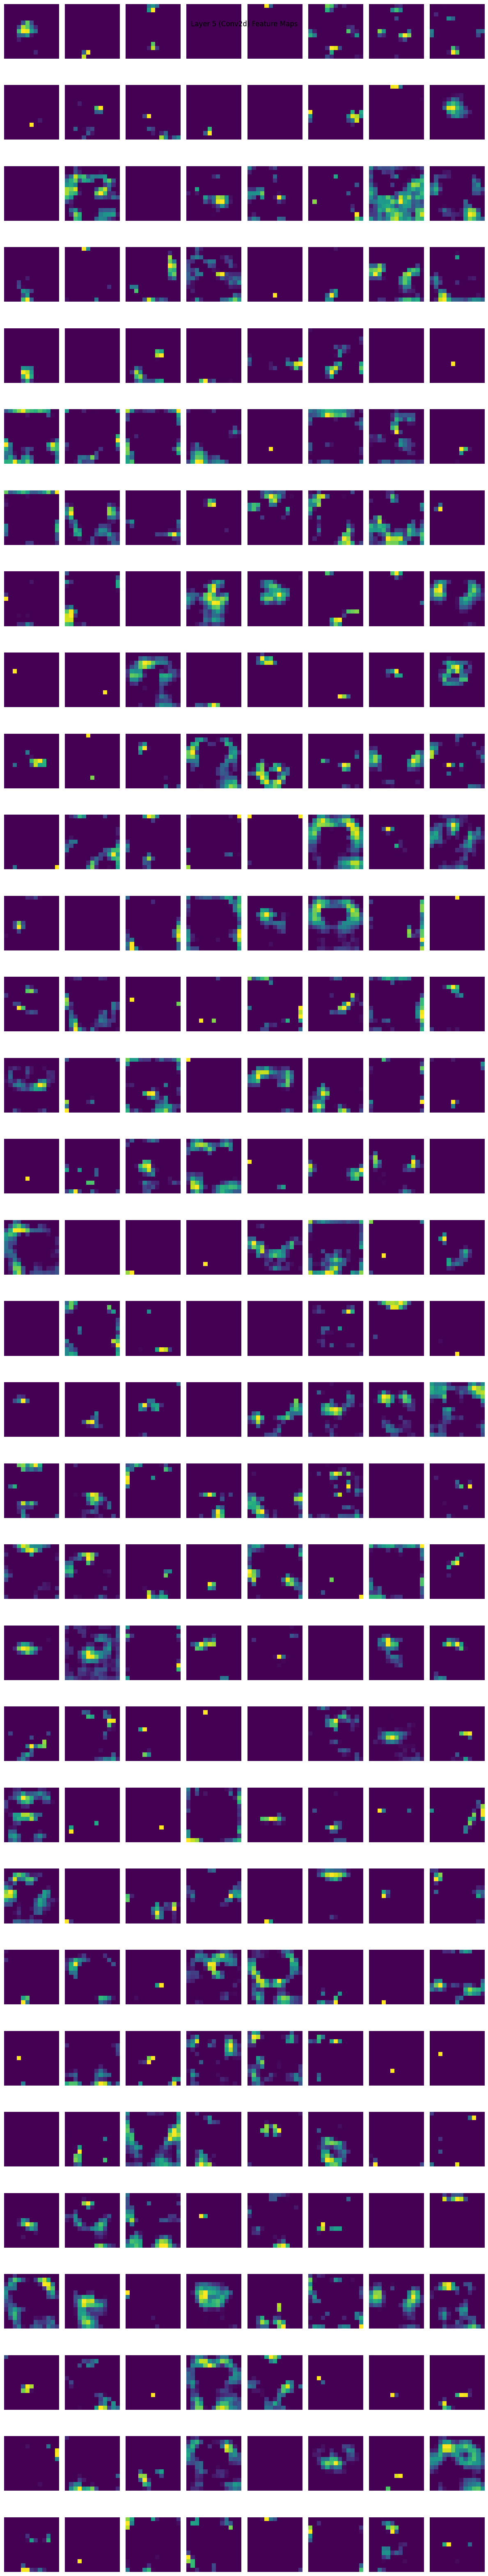

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

# Pre-trained AlexNet model
model = models.alexnet(pretrained=True)
model.eval()

# Preprocessing function for the input image
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# Function to visualize and save feature maps from convolutional layers
def visualize_feature_maps(model, img_tensor, save_dir="feature_maps"):
    # Create directory for saving feature maps if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    activations = []
    layer_names = []

    # Hook function to capture activations from each layer
    def hook_fn(module, input, output):
        activations.append(output)
        layer_names.append(module.__class__.__name__)

    # Register hooks only on convolutional layers
    hooks = []
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Perform forward pass to trigger hooks and store activations
    model(img_tensor.unsqueeze(0))

    # Visualize and save activations for each convolutional layer
    for i, (activation, name) in enumerate(zip(activations, layer_names)):
        activation = activation.squeeze(0).detach().cpu()  # Remove batch dimension
        num_filters = activation.shape[0]
        num_cols = 8  # Number of filters to display in each row
        num_rows = num_filters // num_cols + int(
            num_filters % num_cols != 0
        )  # Rows based on filters

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 2))
        axes = axes.flatten()  # Flatten in case of multiple rows

        for j in range(num_filters):
            if j >= num_rows * num_cols:
                break  # Prevent indexing errors if filters don't fill the grid
            ax = axes[j]
            ax.imshow(activation[j], cmap="viridis")
            ax.axis("off")

        # Hide any remaining axes
        for j in range(num_filters, num_rows * num_cols):
            axes[j].axis("off")

        # Save the figure to a file
        layer_save_path = os.path.join(save_dir, f"layer_{i+1}_{name}.png")
        plt.suptitle(f"Layer {i + 1} ({name}) Feature Maps")
        plt.tight_layout()
        plt.savefig(layer_save_path)  # Save the image
        plt.show()

    # Remove hooks after visualization
    for hook in hooks:
        hook.remove()


# Load and preprocess the image
img_path = "puppy.jpg"  # Replace with your image path
img = Image.open(img_path).convert("RGB")  # Ensure image is in RGB
img_tensor = preprocess(img)

# Visualize and save feature maps from all convolutional layers
visualize_feature_maps(model, img_tensor)